# Problem Set 1 (20 + 40 + 30 = 90 points)

## Important information
1.  We provide signatures of the functions that you have to implement. Make sure you follow the signatures defined, otherwise your coding solutions will not be graded.

2.  Please submit the single Jupyter Notebook file, where only Python and Markdown/$\LaTeX$ are used. Any hand-written solutions inserted by photos or in any other way **are prohibitive and will not be graded**. If you will have any questions about using Markdown, ask them!
3.  The works will be checked for **plagiarism**. The score will be divided by the number of similar works.

4. Some tasks in this assignment are bonus. It means that you can get maximum score for this assignment even if you ignore these tasks. However, if you get $y$ points for bonus tasks and $x$ points for regular tasks, then your score for the assignment will be $\min(90, x+y)$. If $x + y > 90$, then we will label your submission and take into account in the final grade releasing (e.g. in the border case).

## Problem 1. QR backpropagation (20 pts)

Our goal is to write an orthogonalization layer, that for an arbitrary rectangular matrix $A$ produces an orthonormal matrix $Q$ and (optionally) an upper triangualr matrix $R$ such that $A = QR$. 
In other words, we need to compute the QR decomposition.

There are problems when one need to optimize over orthogonal matrices, so using such layer can be a solution.

A standard algorithm to compute the QR decomposition is the Gram-Schmidt process.
For the linearly independent set of vectors $a_1,\dots,a_n$ (that are defined with the matrix $A$) it computes matrix $Q$ that contains orthonormalized set of vectors $q_1,\dots,q_n$.

This algorithm is listed below.

$$
\begin{split}
u_1 &= v_1, \\
u_2 &= v_2 - \frac{(v_2, u_1)}{(u_1, u_1)} u_1, \\
\dots \\
u_n &= v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1}.
\end{split}
$$

Obtained $u_1, \dots, u_n$ are orthogonal vectors in exact arithmetics. Then to make the system orthonormal you should divide each of the vectors by its norm: $u_i := u_i/\|u_i\|$.

We have $A = QR$. 
Matrix $Q$ consists of vectors $u_1, \dots, u_n$. 
Now let's look at the matrix $R$. 

$Q^*A = R$. 
So $R_{i, j} = (u_i, v_j)$ (assuming $u_i$ is already normalized). 
And it is exactly what we see in Gram-Schmidt algorithm:

$$ v_n = \frac{(v_n, u_1)}{(u_1, u_1)} u_1 + \frac{(v_n, u_2)}{(u_2, u_2)} u_2 + \dots + \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1} + u_n.$$ 

This is the representation of vectors $v_i$ in our newly computed ortonormal basis. 
Thus they form matrix $R$. 
These coefficients are in the upper triangular part of $R$, because when $i>j$ we get $R_{i j} = 0$, because then we get sum of scalar products of orthogonal vectors. 

There is a more [computationally stable version of the Gram-Schmidt algorithm](https://en.wikipedia.org/wiki/Gram–Schmidt_process#Numerical_stability) that reduces the loss of orthogonality in matrix $Q$. 
This algorithm is called the modified Gram-Schmidt algorithm.

The loop of orthogonalization is the same, except for the computing the vector $u_k$ simultaneously:

$$ u_n = v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1}
u_n$$

$$ 
 = v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1},
$$

one need to iteratively update $u_k$ step-by-step for a better numerical stability.

$$
\begin{split}
u_k &= v_k - \frac{(v_k, u_1)}{(u_1, u_1)} u_1, \\
u_k &= u_k - \frac{(u_k, u_2)}{(u_2, u_2)} u_2, \\
\dots \\
u_k &= u_k - \frac{(u_k, u_{k-1})}{(u_{k-1}, u_{k-1})} u_{k-1}. \\
\end{split}
$$


You are supposed to do the following tasks:

__1.__ (2 points) Implement the modified Gram-Schmidt algorithm in a function ```modified_gram_schmidt(A)``` using PyTorch.

__2.__ (1 point) Create a random matrix $A \in \mathbb{R}^{m \times n}$, $m \gg n$ and compute gradient $\frac{\partial Q}{\partial A}$ using backpropagation through your implementation of QR decomposition (```modified_gram_schmidt(A)```).

__3.__ (2 points) Compute gradient $\frac{\partial Q}{\partial A}$ using backpropagation through built-in PyTorch function for computing QR decomposition.

In [36]:
# install dependencies
!pip install memory-profiler
import torch

def modified_gram_schmidt(A):
    """
    Computes QR decomposition of matrix A
    
    Input: 
        A - n x m matrix
    Output:
        Q - n x m orthonormal matrix
        R - m x m upper triangular matrix
    """
    
    # Your code here
    n, m = A.shape
    u0 = A[:, 0].clone()
    u0 = u0 / torch.linalg.norm(u0)
    Q = u0.view(1, -1)
    for i in range(1, m):
        u = A[:,i].detach().clone()
        for q in Q:
            c = (torch.dot(u.squeeze(0),q) / torch.pow(torch.linalg.vector_norm(q), 2))
            u = u - c*q
            u = u.view(1, -1)

        u = u / torch.linalg.vector_norm(u)
        Q = torch.concatenate((Q, u), 0)

    R = torch.matmul(Q, A)
    Q = torch.transpose(Q, 0, 1)

    return Q, R
    
    
m = 100
n = 20
A = torch.rand((m, n), requires_grad=True)
# Your code is below
Q1, R1 = torch.linalg.qr(A)
Q2, R2 = modified_gram_schmidt(A)

Q1.retain_grad()
Q2.retain_grad()

loss1 = Q1.sum()
loss2 = Q2.sum()

print('A - Q1R1 ', float(torch.linalg.norm(A - torch.matmul(Q1, R1))))
print('A - Q2R2 ', float(torch.linalg.norm(A - torch.matmul(Q2, R2))))
# Uncomment this code to check the reconstructed tensors:
#print(torch.matmul(Q1, R1)[:5, :5], '\n', torch.matmul(Q2, R2)[:5, :5])

# TODO compute gradients
A.grad = None
Q1.grad = None
loss1.backward()
dL1_dQ1 = Q1.grad.clone().detach()
dL1_dA1 = A.grad.clone()
A.grad = None
Q2.grad = None
loss2.backward()
dL2_dQ2 = Q2.grad.clone().detach()
dL2_dA2 = A.grad.clone()
print(f'dL1/dQ1 {dL1_dQ1}')
print(f'dL1/dA1 {dL1_dA1}')
print(f'dL2/dQ2 {dL2_dQ2}')
print(f'dL2/dA2 {dL2_dA2}')

A - Q1R1  3.6296805774327368e-06
A - Q2R2  7.5851098699786235e-06
dL1/dQ1 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
dL1/dA1 tensor([[ 0.2159,  0.1664,  0.2409,  ..., -0.0876, -0.0665, -0.0765],
        [-0.0302, -0.0004,  0.0147,  ..., -0.0353, -0.0346, -0.0296],
        [-0.2069,  0.2418,  0.2749,  ..., -0.0185, -0.0219, -0.0160],
        ...,
        [-0.2912, -0.2459, -0.2509,  ..., -0.0459, -0.0571, -0.0532],
        [-0.2301,  0.0342,  0.0422,  ..., -0.0361, -0.0275, -0.0360],
        [ 0.0583, -0.1636, -0.2138,  ...,  0.0452,  0.0366,  0.0348]])
dL2/dQ2 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [

__4.__ (13 points total) Write the backpropagation $\frac{\partial Q}{\partial A}$ from scratch with PyTorch. Do not forget to use ```requires_grad=False``` to disable PyTorch autograd accumulation of the gradient.

  a) (2 points) Derive analytically the gradient $\frac{\partial y}{\partial x}$ of vector normalization operation $y := x/\|x\|$.

  b) (1 point) Implement backward through the vector normalization operation (can be implemented either in the function ```backward_normalization``` or further inside the code).

  c) (2 points) Derive analytically the gradient $\frac{\partial u_k}{\partial v_j}$ of the othonormalization operation:

$$
\begin{split}
u_k &= v_k - \frac{(v_k, u_1)}{(u_1, u_1)} u_1, \\
u_k &= u_k - \frac{(u_k, u_2)}{(u_2, u_2)} u_2, \\
\dots \\
u_k &= u_k - \frac{(u_k, u_{k-1})}{(u_{k-1}, u_{k-1})} u_{k-1}. \\
\end{split}
$$

  d) (2 points) Implement backward through the othonormalization operation (can be implemented either in the function ```backward_orthogonalization``` or further inside the code).

  e) (1 point) Implement the QR forward pass (almost identically to ```modified_gram_schmidt```, but with storing the additional data nesessary for backpropagation) with the method ```forward``` of class ```QR``` (see template below).

  f) (5 points) Implement the QR backward pass using previously implemented functions and place it in the method ```backward``` of class ```QR```  (see template below).

__5.__ (2 points) Look at obtained $Q$ and $R$ matrices for each approach (steps 2, 3, 4), verify that $A \approx QR$ and $Q^TQ \approx I$. Measure the required memory for backpropagation (eg. with ```memory_profiler```). 
Compare the results of three approaches: 

- gradient from the PyTorch built-in function
- gradient from PyTorch autograd applied to your function ```modified_gram_schmidt```
- your custom implementation of backward step from analytical expressions. 

Compare the theoretical asymptotics of the memory usage for the backpropagation of the modified Gram-Schmidt algorithm with every approach listed above. 
What data is needed for backpropagation and thus affects the memory consumption?

### Your solution
$\frac{\partial y}{\partial x} = \frac{\mathbb{I}}{||x||} - \frac{x x^T}{||x||^3}$

Because

$\frac{\partial y}{\partial x_i} = \frac{\frac{\partial}{\partial x_i}x\times \Vert x \Vert - x\times \frac{\partial}{\partial x_i} \Vert x \Vert}{ \Vert x \Vert ^2} = \frac{\delta_{ij} \Vert x \Vert - x_i \frac{x_j}{\Vert x \Vert}}{\Vert x \Vert^2} = \frac{\delta_{ij}}{\Vert x \Vert} - \frac{x_i x_j}{\Vert x \Vert^3} $

$\frac{\partial u_k}{\partial v_j} = \prod_{i=1}^{k}(\mathbb{I} - \frac{u_i u_i^{\top}}{u_i^{\top} u_i})$

In [37]:
def backward_normalization(x):

    def get_norma(x):
        buf = (x, torch.linalg.norm(x))
        output = x/torch.linalg.norm(x)
        return output, buf
    
    
    def get_norma_backward(gradient_out_product, buf):
        x, x_norma = buf
        x = x.squeeze()
        inner = x @ x.T
        diff = torch.eye(x.shape[0])/x_norma - inner/torch.pow(x_norma,3)
        gradient_inner_product = torch.matmul(diff,gradient_out_product)
        return gradient_inner_product
    
    
    y, buf = get_norma(x)
    out = get_norma_backward(torch.ones_like(y), buf)
    return out

def backward_orthogonalization(u):
    
    def get_norma(x):
        buf = (x, torch.linalg.norm(x))
        output = x/torch.linalg.norm(x)
        return output, buf
    

    def get_backward(gradint_out_product, buf):
        v, v_norma = buf
        v = v / torch.linalg.norm(v)
        diff = gradient_out_product * (torch.eye(u.shape[0]) - v @ v.T) / v_norma
        gradient_inner_product = torch.matmul(diff,gradient_out_product)
        return gradient_inner_product
    
    
    y, buf = get_norma(u)
    out = get_backward(torch.ones_like(y), buf)
    return out

class QR():
    def forward(self, A):
        """
        Computes QR decomposition of matrix A

        Input: 
            A - n x m matrix
        Output:
            Q - n x m orthonormal matrix
            R - m x m upper triangular matrix
        """
        n, m = A.shape
        u0 = A[:, 0].detach().clone()
        u0 = u0/torch.linalg.norm(u0)
        Q = u0.view(1, -1)
        for i in range(1, m):
            u = A[:,i].clone()
            for q in Q:
                c = (torch.dot(u.squeeze(0),q)/torch.pow(torch.norm(q), 2))
                u = u - c*u
                u = u.view(1, -1)
            u=u/torch.norm(u)
            Q = torch.cat((Q, u), 0)
        R = torch.matmul(Q, A)
        Q = torch.transpose(Q, 0, 1)
        self.A = A
        self.Q = Q
        self.R = R
        
        return Q, R
        

    def backward(self, gradient_out_product):
        """
        Computes QR decomposition of matrix A

        Input: 
            grad_output - n x m matrix, derivative of the previous layer L: dL/dQ (torch.ones in our case)
        Output:
            grad_input - n x m derivative dL/dA
        """
        # Your code
        Q, R = self.Q, self.R
        A = self.A
        
        dL_dQ = grad_output
        dQ_dR = torch.zeros_like(R)
        for i in range(R.shape[0]-1, -1, -1):
            for j in range(i, R.shape[1]):
                if i == j:
                    dQ_dR[i][j] = 1
                else:
                    dQ_dR[i][j] = (-1 * R[i][j]) / R[i][i]
        grad_input = dL_dQ @ R.T @ Q.T + gradient_out_product @ dQ_dR @ Q.T
        return grad_input

In [3]:
# qr = QR()
# A = torch.rand((m, n))

# Q, R = qr.forward(A)
# loss1 = Q.sum()

# # TODO compute losses and do backpropagation
# # compute dL / dQ and finally dL / dA
# ...
# dL_dA = ...


# A_autograd = A.clone().detach().requires_grad_(True)
# Q_autograd, R_autograd = qr.forward(A_autograd)
# loss2 = Q_autograd.sum()
# loss2.backward()
# print('Difference between gradients:', float(torch.linalg.norm(dL_dA - A_autograd.grad)))

### Bonus tasks

__6.__ (10 points) Modify the previous code to be memory-efficient. 

Hint: not all intermediate variables need to be stored for backpropagation.

__7.__ (3 points) Again, measure the required memory for backpropagation. Explain the theoretical asymptotics of the memory usage for the memory-efficient backpropagation.

In [4]:
# Your solution is here

## Problem 2. Voice classification (40 pts)

In this assigment you will have a chance to develop a voice-anti-spoofing algorithm, enhancing your skills in standard PyTorch classificaton development pipeline.

There are several types of attack: 
- replay attacks, when one records and repeats someone's voice, 
- impresario attacks, when the speaker mimics the target's voice like an actor and 
- the most interesting are deepfake attack, based on text-to-speech, voice cloning and voice conversion algorithms. 

In this work we will focus on deepfake attack and try to differ them from genuine (or bona-fide) speech.

We will use data, provided by organisers of biannual [ASVspoof](https://www.asvspoof.org/) contest. More precisely, we will take subpart `ASVspoof_2019LA` dataset, which consist of 17 different attacks DF attack types and bona-fide. All recordings were augmented to be close to real telephone recordings. We will not take 2021 data, but if you want, you can use 2021 data as test and 2019 data as train and validation.

The initital dataset can be downloaded from [here](https://datashare.ed.ac.uk/handle/10283/3336). However, we [provide you smaller subsample](https://drive.google.com/drive/folders/1-CyCFA3komqrtyoYj21y5gzfh_vcKBYx?usp=share_link) of dev (val) and eval (test) parts to make work in colab relatively possible :) . You can download it locally or put into you Drive. You will need around 3GB free space, think about creating a new account if you don't have enough.

We encourage you to look through data [overview](https://datashare.ed.ac.uk/bitstream/handle/10283/3336/asvspoof2019_evaluation_plan.pdf?sequence=1&isAllowed=y) and result summary [paper](https://datashare.ed.ac.uk/bitstream/handle/10283/3336/asvspoof2019_Interspeech2019_submission.pdf?sequence=2&isAllowed=y).

One important thing to notice: main application of this algorithms is in voice-biometry, when we want to stop illegal intruder. Thus, there are two (or 3) common ways of developing VAS algorithms: speaker-aware, we we train verification model which is sensitive to spoofing and differs bona-fide and impostor or we combinde verification score and score of VAS model to decide, whetherr the person is the same, and finally simple and general countermeasures setup, when given audio and model should predict whether it is a spoof or bona-fide. We will work on the last setup.

**Important: feel free not to use pre-defined functions, you can solve the task as you wish or change functions/pipelines significantly.** 

#### Preparations
It is a good practice to log and check you experiments. In this assignemnt, we ask you to sign up in wandb, log your experiments and give us a link to your project and attach plots/report in the notebook with your solution.

In [5]:
!pip install wandb

import copy
import os
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from typing import Optional
import torch
import torch.nn as nn
import torchaudio
import librosa
import sklearn.metrics as metrics
import wandb
from torchvision.models import resnet50, resnet18
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve

# my imports 
!pip install pyyaml
import yaml

In [6]:
# https://wandb.ai/quickstart

!wandb login  # and paste your API key from https://wandb.ai/authorize

wandb: Currently logged in as: sherkidanil (dp_new). Use `wandb login --relogin` to force relogin


In [7]:
# wandb.init(project="voice-anti-spoofing", name = "test_run", tags = ["SmallModel", "LA"])
SEED = 42  # do not change it
# mount drive if you wish

# from google.colab import drive
# drive.mount('/content/drive/')

# %cd /content/drive/MyDrive/

In [8]:
!ls for_colab

ASVspoof2019_LA_cm_protocols  flac_dev	flac_eval  README.LA.txt  train_flac


In [9]:
# to make dataframes
path_la_train = "for_colab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
path_la_dev = "for_colab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
path_la_eval = "for_colab/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

flac_la_train = "for_colab/train_flac/"
flac_la_dev = "for_colab/flac_dev/"
flac_la_eval = "for_colab/flac_eval/"

In [10]:
columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
df = pd.read_csv(path_la_train, sep=" ", header=None)
df.columns = columns
df.head()

,speaker_id,audio_file_name,system_id,skip,class
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


In [11]:
def makedf_ultimate(txt_file_path, flac_path, dataset_name='ASVspoof', data_type='LA', year=2019):
    
    if dataset_name=='ASVspoof':
        name = dataset_name+str(year)+data_type
        if data_type=='DF':
            attack_name = 'deepfake'
        elif data_type=='LA':
            attack_name = 'deepfake'
        else:
            attack_name = 'replay'
            
        df = pd.read_csv(txt_file_path, sep=" ", header=None)

            
        if year == 2019:
            df.columns = ["speaker_id", "audio_file_name", "system_id", "skip", "class"]
            df['dataset'] = name
            di = {'bonafide':0, 'spoof':1} # assign classes

            df['class'] = df['class'].map(di)
            # m = df['class'] == 0
            # df.loc[m, 'attack'] = 'noattack'
            df['audio_path'] = flac_path + df['audio_file_name'] + '.flac'
            df = df[["speaker_id", "audio_path", "class"]]
        
    # df = df[['audio_path', 'class', 'dataset', 'attack']]
    df = df[["speaker_id", "audio_path", "class"]]
    df = df.reset_index(drop=True)
    return df

In [12]:
df_train = makedf_ultimate(path_la_train, flac_la_train, year=2019, data_type='LA')
df_dev = makedf_ultimate(path_la_dev, flac_la_dev, year=2019, data_type='LA')
df_eval = makedf_ultimate(path_la_eval, flac_la_eval, year=2019, data_type='LA')

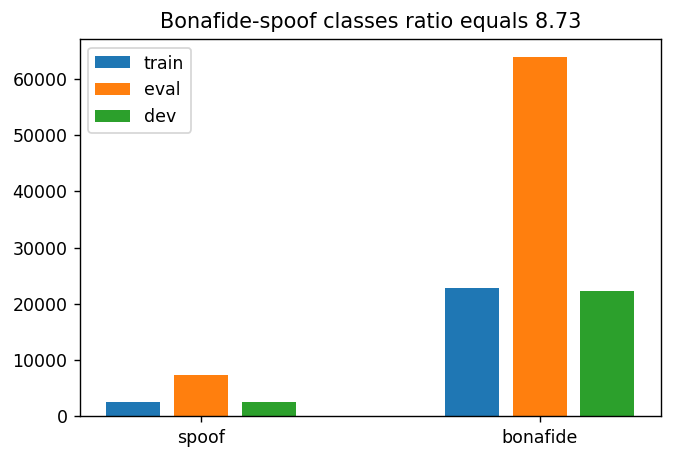

In [13]:
plt.figure(dpi = 125)
x_plot = np.array([5, 10])
plt.bar(x_plot - 1, [df_train['class'].value_counts()[0], df_train['class'].value_counts()[1]],
       label = 'train')
plt.bar(x_plot, [df_eval['class'].value_counts()[0], df_eval['class'].value_counts()[1]],
       label = 'eval')
plt.bar(x_plot+1, [df_dev['class'].value_counts()[0], df_dev['class'].value_counts()[1]],
       label = 'dev')
plt.xticks(x_plot,['spoof', 'bonafide'])
bnfd, spf = 0, 0
for item in [df_train, df_eval, df_dev]:
    bnfd += item['class'].value_counts()[1]
    spf += item['class'].value_counts()[0]
plt.title(f'Bonafide-spoof classes ratio equals {bnfd/spf :.2f}')
plt.legend()
plt.show()

**Task 1.1 (2 points)** Check data distribution. Is it imbalanced? How are you going to deal with it?

Hints: upsampling, downsampling, add new data, e.g. from this [source](https://commonvoice.mozilla.org/) (but will new audios have the same distribution?), or adjust loss functions.

**Answer**

Yes, It's absolutely imbalanced. Fro solve this problem with imbalanced dataset, I suppose three different ways^

* upsampling - repeat 'spoof' class samples ```num_spoof/num_bonafide``` - I think I don't want to use this technique because this data will be not augmented;
* downsampling - delete 'bonafide' calss samples from initial data -It's maybe useful technique for our study task in respect to small GPU resources;
* add new data - from source - good idea;
* adjust loss function - for example Focal loss for convolutional neural networks (CNNs: U-Net (Olaf Ronneberger 2015), ResUNet (Foivos I. Diakogiannis 2019), LinkNet (Abhishek Chaurasia 2017)) eliminates the class imbalance problem - another good idea, because there are many special losses, which developed for imbalanced classes problem (for example, focal loss for semantic segmentation).

In [14]:
# for dev and eval, let's simplify the task and use smaller amount of data, but balanced to better understand metrics
# we need this functions, because it removes unuploaded data from our dataframes
def balanced_split(df):
    k = min(len(df[df['class']==0]), len(df[df['class']==1]))
    print(k)
    df_bf = df[df['class']==0].sample(frac=1, random_state=SEED).iloc[0:k]
    df_spoof = df[df['class']==1].sample(frac=1, random_state=SEED).iloc[0:k]

    df_bf = df_bf.append([df_spoof], ignore_index=True)
    df_bf = df_bf.reset_index(drop=True)
    return df_bf

df_eval = balanced_split(df_eval)
df_dev = balanced_split(df_dev)

7355
2548


/tmp/ipykernel_1586/4072736431.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_bf = df_bf.append([df_spoof], ignore_index=True)


In [15]:
# for audio manipulations we advise you to use torchaudio or librosa
x, sr = torchaudio.load(df_eval["audio_path"].iloc[0])

In [16]:
ipd.display(ipd.Audio(x, rate=sr))

**Task 1.2. (1 point)** Display several spoof and bona-fide audios. Can you hear the difference?

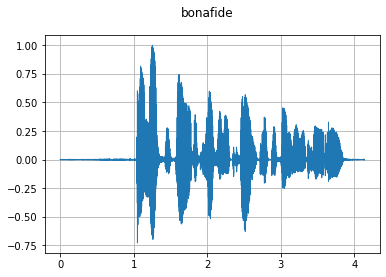

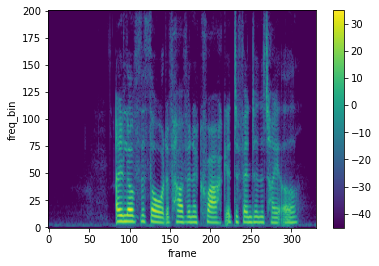

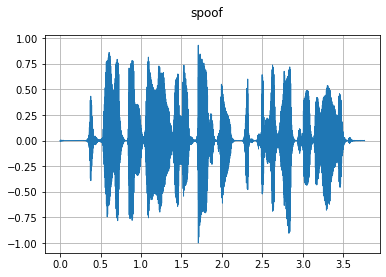

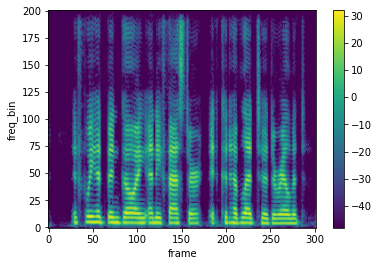

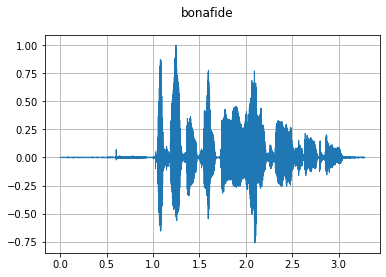

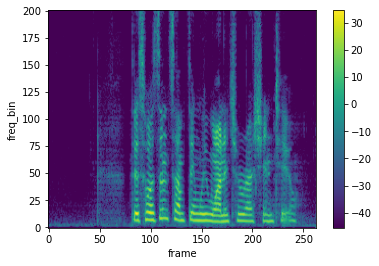

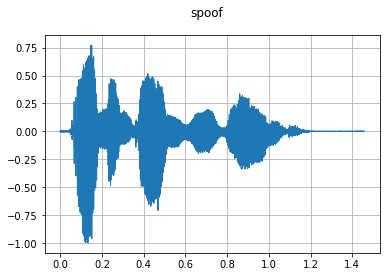

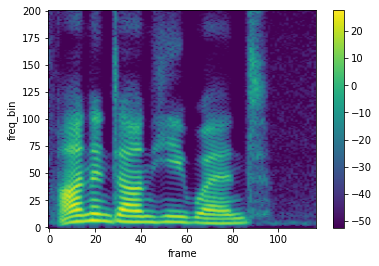

In [17]:
### Your code is here

def plot_waveform(waveform, sample_rate, title = 'waveform'):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_spectrogram(waveform, title=None, ylabel="freq_bin"):
    spectrogram = torchaudio.transforms.Spectrogram()
    specgram = spectrogram(waveform)[0]
    fig, axs = plt.subplots(1, 1)
    if title is not None:
        axs.set_title(title)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
# reference to code https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html


for i in [0, 14709, 1, 14708]:
    x, sr = torchaudio.load(df_eval["audio_path"].iloc[i])
    plot_waveform(x, sr, 'bonafide' if df_eval['class'].iloc[i]==0 else 'spoof')
    plot_spectrogram(x)
    ipd.display(ipd.Audio(x, rate=sr))

Yes, the difference definitely exists. 

Definitely heard a more robotic voice.

If we try to plot waveform, we can see the difference on the plot. The difference is steeper line, more sharp transitions from wave to wave, and of course there is no microphone noise. 

### Custom dataset and Model

You can find inspiration and hints in 
- https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://pypi.org/project/audiomentations/ 
- https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html
- and any other blogposts about spectrograms

**Task 2.1 (5 points)** We can work with audios as with images, transforming into spectrograms. Here your task is to implement simple model, which receives raw wav (amplitudes, but probably already preprocced in dataset), transforms it into mel-spectrogram, changes amplitude to DB scale (if you want) and then procceses through the layers. You are free to use ready pre-trained backbones, e.g. from `torchvision.models` and fine-tune them. However, if you want to practise more, create something on your own. Large models with `requires_grad=True` for all parameters will probably result in problems on training in colab. 

In [18]:
class WavResNet(nn.Module):
    def __init__(self, classes=None, resample=16000, n_mels=80, melspec_config=None):
        super().__init__()
        self.fbank = torchaudio.transforms.MelSpectrogram(sample_rate=resample, n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        
        model = resnet18(pretrained=True)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, classes)
        # or create your own layers and use them in forward pass
        self.network = model
        
    
    def forward(self, x, wav_lens: Optional[torch.Tensor]=None):  # can check the length if you want. this is helpful for inference
        x = x.squeeze(1)
        mels = self.fbank(x)
        mels_db = self.to_db(mels)
        mels_db = mels_db.unsqueeze(1)
        out = self.network(mels_db)  
        return out

**Task 2.2 (1 point)**
In your opinion, which approach is better for binary classification: 
- Model's last layer output has shape 1, train with BCE-like loss.
- Model's last layer output has shape 2, train with cross-entropy like loss. 

---
Both approaches can be effective for binary classification, but the second approach of using a model's last layer output with two nodes and training it with cross-entropy loss is usually preferred. This is because cross-entropy loss takes into account the probabilities of both classes, and can therefore better differentiate between the two classes. On the other hand, BCE-like loss only considers the probability of one class and may not be as effective in handling imbalanced classes.

**Task 2.3 (3 points)** Create custom dataset, which recieves ```df``` and returns preprocessed audio.

**Task 2.4 (1 point)** Should we use augmentaions? If yes, which ones?

--- 
About augmentaions.

There are specific augmentation techniques for audio samples. For examples, one of researchers use the follows techniques:

* **Noise.** Random selection noise from MUSAN and addition to the original recording (0-15dB SNR).
* **Speed.** Artificially change speed of file (via FFT resampling). Speed can be chosen randomly from [0.9, 1.0, 1.1].
* **Reverb.** Artificially reverberated a signal via convolu- tion with real RIRs.
* **Spectral augmentation.** Using```SpecAugment``` to the input log Mel-spectrograms and randomly masked 0 to 5 frames in the time domain and 0 to 10 frequency bins.

In [19]:
class DatasetWav(Dataset):
    def __init__(self, data_frame, padding_sec=4, default_sr=16000, transform=None):
        self.df = data_frame
        self.padding_sec = padding_sec
        self.default_sr = default_sr
        self.labels = self.df['class'].tolist()
        self.paths = self.df['audio_path'].tolist()
        self.transform = transform
        # self.vad = ...  # in this task you are free to omit it in order to speed up calculations,
                          # also the provided data should be rather clean

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        label = self.labels[idx]
        path = self.paths[idx]
        waveform , sr = torchaudio.load(path, normalize=True) # normalize=True
        # transform waveform from stereo to mono channel 
        waveform = torch.mean(waveform, dim=0, keepdim=True)
        resample_transform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.default_sr) # should we use it for our data or can omit? 
        waveform = resample_transform(waveform)
        # waveform = self.vad(waveform)

        # came up with idea, what to do if audio is longer or shorter than reuqired
        waveform_len = waveform.shape[1]
        desired_len = self.padding_sec * self.default_sr
        if waveform.shape[1] <  self.padding_sec * self.default_sr:
            difference =  self.padding_sec * self.default_sr - waveform.shape[1]
            padding = torch.zeros((1, difference))
            waveform = torch.cat([waveform, padding], dim=1)
        else:
            crop = self.padding_sec * self.default_sr
            waveform = waveform[:, :crop]

        if self.transform is not None:
            waveform = self.transform(waveform)

        return waveform, label

In [20]:
# check that works
batch_size = None
train_dataset_wavs = DatasetWav(df_train) #.iloc[0:200]
train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
x, y = next(iter(train_dataloader_wavs))
model = WavResNet(classes = 2)
model(x)

/home/d_sherki/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/d_sherki/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[-0.5251,  0.7434]], grad_fn=<AddmmBackward0>)

### Train and Test functions
**Task 3.0 (1 point)** What is the difference between `model.train()` and `model.eval()`? Does `model.eval()` mode take gradient statisitcs into account?

---
In PyTorch, the `model.train()` and `model.eval()` modes are used to indicate whether the model is in training mode or evaluation mode. 

During training, `model.train()` is called to put the model in the training mode. In this mode, the model calculates and accumulates the gradients of the loss function with respect to the model parameters. This is important because it enables us to update the model parameters using an optimizer algorithm (e.g. Stochastic Gradient Descent) with the accumulated gradients. 

On the other hand, during evaluation or testing, `model.eval()` is called to put the model in the evaluation mode. In this mode, the model is not training and does not calculate or accumulate the gradients. Instead, it uses the learned weights to make predictions on the test set. 

To answer the second part of the question, no, `model.eval()` mode does not take gradient statistics into account as it does not compute gradients at all.

---

**Task 3.1 (5 points)** Implement train and test functions, which iterate over all batches. Do logging of loss, accuracy on each batch and after every epoch. Check equal error rate EER, explain, what is it.

---
**EER (Equal Error Rate)** is a metric used to evaluate the performance of binary classification models. It is the error rate at which the **False Positive Rate (FPR)** and the **False Negative Rate (FNR)** are equal. In other words, it is the point on the ROC curve where the FPR equals 1 - TPR. It is typically used in situations where the cost of False Positives and False Negatives is roughly equal.

In [21]:
def calculate_eer(y, y_score):
    fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)
    return eer, thresh

In [22]:
def train(model, dataloaders, criterion, optimizer, 
          num_epochs=3, scheduler=None, savename=None,
          print_counter=10, decay_factor=10,
          device=torch.device("cuda")):
    '''
    :param model: torch.model;
    :param dataloders: dict; // {'train:'train_loader, 'val': val_loader}
    :param criterion: torch.criterion;
    :param optimizer: torch.optim;
    :return: tuple. // (model, val_acc_history) - model in min val_loss point
    '''
    val_acc_history = []

    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
                train_batch_loss = []
            else:
                model.eval()
                val_batch_loss = []

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        train_batch_loss.append(loss.item())
                        wandb.log({'train_loss_batch': loss.item()})
                    else:
                        val_batch_loss.append(loss.item())
                        wandb.log({'test_loss_batch': loss.item()})

                    _, preds = torch.max(outputs, 1)
                    if phase == 'val':
                        eer, thr = calculate_eer(labels.cpu().detach().numpy(), 
                                                 preds.cpu().detach().numpy())
                        wandb.log({'val_err_batch': eer,
                                  'threshold': thr})

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('For {} epoch {} loss: {:.4f}, accuracy: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        wandb.log({'train_loss': np.mean(train_batch_loss), 
                   'val_loss': np.mean(val_batch_loss),
                   'best_val_acc': best_acc})

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_weights)
    if savename is not None:
        torch.save(model, f'{savename}.pth')
    return model, val_acc_history

def test(model, test_dataloader, criterion=None, device=torch.device("cuda"), savename=None):
    y, probs = [], []
    model.eval()
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs.append(outputs)
        _, preds = torch.max(outputs, 1)
        y.append(preds)
    return y, probs

### Main loop 

**Task 4.1 (3 points)** What loss will you choose and why? What it should receive for input (logits, probs)? Explain your answer.
Consider also:
- https://medium.com/swlh/focal-loss-what-why-and-how-df6735f26616
- https://libauc.org/

As we said in the beginning, a good option is to use a cross-entropy loss with a two-output model (that's what I did). Considering that by reducing all available datasets at the beginning to eliminate class imbalances, we can conclude that the cross-entropy loss will work well.

We can also say that if we were to use the entire dataset with class imbalances, it would be good to use FocalLoss (as I also wrote above)



**Task 4.2 (5 points)** Implement main function, which receives yaml or json config (or path to it) and train and test the model, save model checkpoints, and model's test predictions. At least, you should obain results better than random. It is good, if accuracy on test dataset is >= 0.75.

In [24]:
import warnings
warnings.filterwarnings("ignore")

def dict2yaml(dict_file, path='config.yaml'):
    '''
    :param dict_file: dict;
    :param path: str.
    '''
    with open(path, 'w') as file:
        documents = yaml.dump(dict_file, file)

def yaml2dict(path):
    '''
    :param path: str;
    :return: dict.
    '''
    with open(path, "r") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data

def main(config):
    '''
    :param config: str. //path to yaml file 'config.yaml'
    '''
    config = yaml2dict(config)
    
    lr =  config['lr']
    epochs = config['epochs']
    batch_size = config['batch_size']
    alpha = config['alpha']
    config_for_wndb = {
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "optimizer": config['optimizer'].__name__,
        "alpha": alpha
    }
    wandb.init(project="voice-anti-spoofing", name = "test_run", tags = ["ResNet", "LA"], config = config_for_wndb)

    # debug firstly on small subpart of dataset
    train_dataset_wavs = DatasetWav(df_train) #.iloc[0:200]
    train_dataloader_wavs = DataLoader(train_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
    val_dataset_wavs = DatasetWav(df_dev) 
    val_dataloader_wavs = DataLoader(val_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
    test_dataset_wavs = DatasetWav(df_eval)
    test_dataloader_wavs = DataLoader(test_dataset_wavs, batch_size=batch_size, shuffle=True, num_workers=8)
    dataloaders = {"train": train_dataloader_wavs, "val": val_dataloader_wavs}
    
    device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classes = 2                                          
    model = WavResNet(classes=classes)                                                                             
    model = model.to(device)
    # freeze layers except the last one if you want
    for param in model.parameters():
        param.requires_grad = True
    model.network.fc.requires_grad_(True)
                                                                                           
    optimizer = config['optimizer'](model.parameters(), lr)
    scheduler = config['scheduler']
    sc = torch.tensor([alpha, 1 - alpha]).to(device) # weights for loss
    criterion = nn.CrossEntropyLoss(weight=sc)
    
    for_ckpts = "."
    os.makedirs(for_ckpts, exist_ok=True)
    
    model, val_acc_history = train(model, dataloaders, criterion, 
                                   optimizer, num_epochs=epochs,
                                   savename = config['savename'],
                                  scheduler = scheduler)
    
    y, probs = test(model, test_dataloader_wavs)
    
    return y, probs

path = 'config.yaml'

yaml_dict = {
    'lr': 0.001,
    'epochs': 1,
    'batch_size': 256,
    'alpha': 0.5,
    'optimizer': torch.optim.Adam,
    'scheduler': None,
    'savename': f'resnet18_{torch.optim.Adam.__name__}',
}

dict2yaml(yaml_dict, path)

y, probs = main(path)


best_val_acc,▁
test_loss_batch,▇▄▃▇▄█▇▂▅▆▂▃▄▄▆█▇▆█▁
threshold,█▁███▅██▅██▄██▅██▁██
train_loss,▁
train_loss_batch,██▇▇▆▅▅▅▅▄▄▄▃▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▂▁▂▁▃
val_err_batch,▆▅▆▆▆▃▆▆█▆▆▃▆▆█▆▆▁▆▆
val_loss,▁
best_val_acc,0.50039
test_loss_batch,0.88057
threshold,1.5
train_loss,0.46893


OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB (GPU 0; 10.91 GiB total capacity; 9.77 GiB already allocated; 97.44 MiB free; 9.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Training might require a long time. So, you can try to use subpart of the dataset to receive rather good results. Also, you don't have to train for many epochs, 1 or even a half of epoch might be enough. Also consider to make some speedups in the model and dataset.

Colab also might work unstable with lots of data. If this happens, think how to deal with it, e.g. restart the kernel and/or remove the majority of data from Drive and try to bugfix firstly, then do train and test separately. 



**Task 4.3 (5 points)** Analyze the results. Play some audios with wrong predictions. Plot prediction distributions vs class. Is it possible to find better threshold?


*Threshold*

If you look at the results, you can see in the ```wandb``` reports that a treshold equal to 1 is optimal for most cases (except for the wrong learning rate

**Task 4.4 (5 points)** Discuss the results and your approaches + hyperparameters. If you can, run some experiments with different parameters.

 Write your ideas, what else you can try to improve the results in the future.
 
 
For this task AdamW with batch size 256 turned out to be the best option.

It turned out that if you use pretrained model ResNet-18 with overtraining

Small learning rate allows to avoid re-learning at the first epoch, as well as large batch size

A large learning rate immediately leads to re-learning

Which I could have done better:

* implement Lion optimizer
* take a big dataset
* use Focal loss to avoid class imbalance
* use augmentation

**Task 4.5 (3 points)** Provide link to wandb project, or link to report. Upload best model's weights to Drive and provide a link with access right.


In [ ]:
# Your solution is here

# https://wandb.ai/dp_new/voice-anti-spoofing?workspace=user-sherkidanil

**Bonus task. (50 points)** 

So far, we didn't care about speaker_id and verification. Take verification model from whatever you want and create counter measure subnetwork, as described in this [article](https://sasv-challenge.github.io/pdfs/2022_descriptions/IDVoice.pdf). Train the model, as described there. ASVspoof also provides Enrollment(anchor) recordings. Try to make blending, to obtain better metrics for counter measures.

These links might be helpful:
- https://github.com/archinetai/surgeon-pytorch
- https://www.kaggle.com/code/peter0749/additive-margin-softmax-loss-with-visualization

## Problem 3. (30 pts)

### Task 1 (10 pts)

For FCNN (Fully connected Neural Networks)
\begin{equation}
f(x)=f_k\left(f_{k-1}\left(\ldots\left(f_0(x)\right)\right),\right.
\end{equation}
assume the nonlinearity function $\sigma$ is ReLU and loss function $L$ is squared error loss function.
Prove that the deep learning model is not unique for any datasets, i.e. the optimization problem 
\begin{equation}
\min_\theta \ g(\theta)=\frac{1}{N} \sum_{i=1}^N L\left(y_i, \hat{y}_i\right), \text{where} \ \ \hat{y}_i=f\left(x_i, \theta\right),
\end{equation} 
dose not have an unique global minimizer $\theta$.

---
### Soltion

Suppose we have a fully connected neural network with two layers. 

In this case, we can express the output of the first layer as $z_1 = \mathbf{W_1} x_1+b_1 $, and the activation of the first layer as $\mathrm{ReLU}(\mathbf{W_1} x_1+b_1)$. The output of the second layer can be written as $\mathbf{W_2} (\mathrm{ReLU}(\mathbf{W_1} x_1+b_1))+b_2$. Assuming that the biases $b_1$ and $b_2$ are equal to zero, we can simplify this expression to $\mathbf{W_2}  \mathrm{ReLU}(\mathbf{W_1} x_1)=\mathbf{W_1} \mathbf{W_2}  \mathrm{ReLU}(x_1)$. If the product of the weight matrices $\mathbf{W_1} \mathbf{W_2}$ is equal to some other matrices $\mathbf{W_1}^{*} \mathbf{W_2}^{*}$, the networks will yield the same output with different weights. Because the outputs are the same, the loss values will also be equal, which means that the networks global minimum values will be identical.

### Task 2 (5 pts)

The *softmax* activation function is 
\begin{equation}
\mathrm{Softmax}(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \ \text { for } \  i=1, \ldots, K \text { and } \mathbf{z}=\left(z_1, \ldots, z_K\right) \in \mathbb{R}^K.
\end{equation}
Suppose $\mathbf{z} \in \mathbb{R}^K$, and $\mathbf{a} \in \mathbb{R}^K$,
Prove that for the optimization problem
\begin{equation}
\begin{aligned}
& \min_{\mathbf{a}} \ -\langle\mathbf{a}, \mathbf{z}\rangle+\langle\mathbf{a}, \log \mathbf{a}\rangle \\
& \text { s.t. } \sum_k^K \mathbf{a}_{k}=1,
\end{aligned}
\end{equation}
the minimizer is 
\begin{equation}
\mathbf{a}^*=\mathrm{Softmax}(\mathbf{z}).
\end{equation}

*Hint*: KKT optimality conditions and convexiy of the problem can help you to show the required equality

---
### Solution
---

Let's first write down the Lagrangian of the optimization problem:
\begin{equation}
\mathcal{L}(\mathbf{a},\lambda)= -\langle\mathbf{a}, \mathbf{z}\rangle+\langle\mathbf{a}, \log \mathbf{a}\rangle + \lambda\left(\sum_k^K \mathbf{a}_{k}-1\right).
\end{equation}
The KKT optimality conditions for this problem are:
\begin{align}
&\nabla_{\mathbf{a}} \mathcal{L}(\mathbf{a},\lambda) = -\mathbf{z}+\log \mathbf{a}+ \mathbf{1}\lambda = \mathbf{0} \\
&\sum_k^K \mathbf{a}_{k}=1 \\
&\mathbf{a}_{k}\geq 0, \ k=1,\ldots,K \\
&\lambda \geq 0 \\
&\lambda \left(\sum_k^K \mathbf{a}_{k}-1\right)=0.
\end{align}

We can rewrite the first optimality condition as follows:
\begin{equation}
e^{\log \mathbf{a}}=e^{\mathbf{z}-\mathbf{1}\lambda}.
\end{equation}

Taking the sum over both sides, we get
\begin{equation}
\sum_{k=1}^K e^{\log \mathbf{a}_k}=\sum_{k=1}^K e^{z_k-\lambda}.
\end{equation}

Since $\sum_k^K \mathbf{a}_{k}=1$, we have that

$$\sum_k e^{z_k+\lambda-1} = 1\\ $$
$$\sum_k e^{z_k} \sum_k e^{\lambda - 1} = 1$$
$$ e^{\lambda-1} = \frac{1}{\sum_k e^{z_k}}$$
$$a^*=e^{z+\lambda -1} \Rightarrow a^*=e^{z} e^{\lambda-1}$$

Inserting the last but one in the last we will get:

$$\mathrm{Softmax}(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$$

---

### Task 3 (15 pts)

For function $f(x)=x^2, x \in \left[0, 1\right]$, 

1) prove that the neural network $\hat f(x)$ based on the following structure has the approximation error 
\begin{equation}
|f(x)-\hat f(x)|\leq \frac{1}{2^{n-1}}
\end{equation}
where $n$ is the number of layers in the nural network.

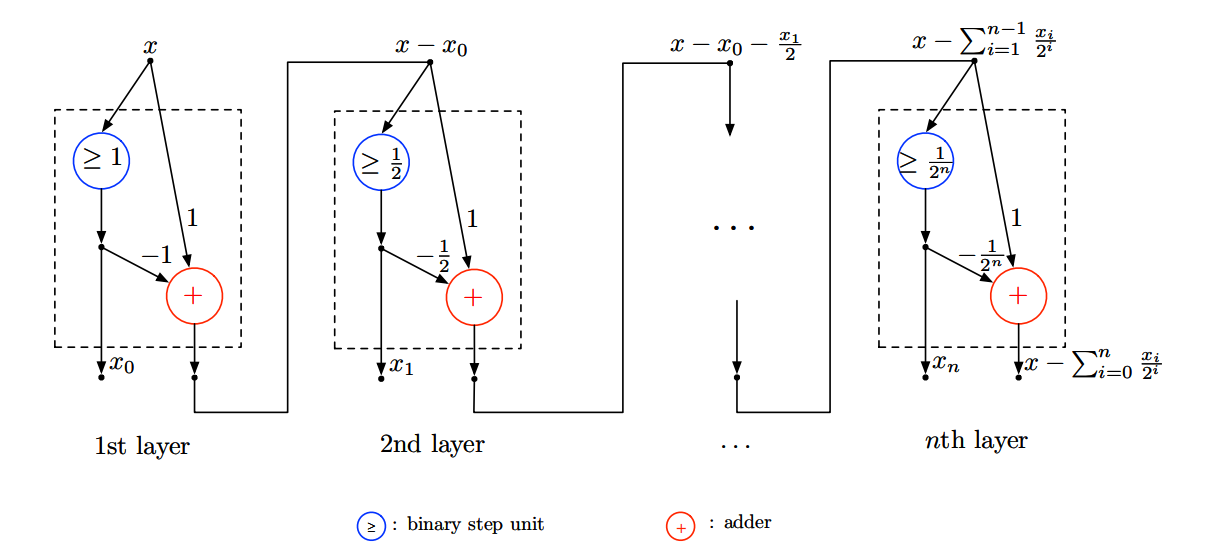

*Hint*: For each $ x \in \left[0, 1\right]$, $x$ can be denoted by its binary expansion $x=\sum_{i=0}^{∞} x_i/2^i$, where $x_i \in \{ 0, 1\}$. The above structure can be used to find $x_0,\dots, x_n$. Then we can write $\hat f(x)=f\left(\sum_{i=0}^{∞} x_i/2^i\right).$

After the proof, if we want to achieve $\epsilon$ appoximation error based on the above neural network, the number of layers $n$ has to satisfy the condition $\frac{1}{2^{n-1}}\leq \epsilon$, i.e. $n\geq \log_2 \frac{1}{\epsilon}$.

### Solution

The difference between $f(x)$ and $\hat{f}(x)$ can be expressed as
\begin{equation}
|f(x)-\hat{f}(x)|=\left(x-\sum_{i=1}^n \frac{x_i}{2^i}\right)\left(x+\sum_{i=1}^n \frac{x_i}{2^i}\right), 
\label{eq:difference}
\end{equation}
where $n$ is the number of terms used in the approximation of $f(x)$.

Expanding the first factor, we get
\begin{align*}
x-\sum_{i=1}^n \frac{x_i}{2^i}&= \frac{2^n}{2^n}x - \sum_{i=1}^n \frac{x_i}{2^i} \\
&= \frac{2^n}{2^n}x - \sum_{i=0}^{n-1} \frac{x_{i+1}}{2^{i+1}} \\
&= \frac{2^n}{2^n}x - \frac{1}{2}\sum_{i=1}^{n} \frac{x_{i}}{2^{i-1}} \\
&= \frac{2^n}{2^n}x - \frac{1}{2}\left(\sum_{i=0}^{n} \frac{x_{i}}{2^{i-1}} - x_{0} \right) \\
&= \frac{2^n}{2^n}x - \frac{1}{2}\left(x + \sum_{i=1}^{n} \frac{x_{i}}{2^{i-1}} - x_{0} \right) \\
&= \frac{2^n-1}{2^n}x + \frac{1}{2}\left(x_{0} - \sum_{i=1}^{n} \frac{x_{i}}{2^{i-1}} \right)
\end{align*}
where $x_0$ is the first digit to the right of the decimal point in the binary expansion of $x$. 

Substituting this expression into Eq.~\eqref{eq:difference}, we obtain
\begin{align*}
|f(x)-\hat{f}(x)| &= \left(\frac{2^n-1}{2^n}x + \frac{1}{2}\left(x_{0} - \sum_{i=1}^{n} \frac{x_{i}}{2^{i-1}} \right)\right)\left(x+\sum_{i=1}^n \frac{x_i}{2^i}\right) \\
&= \frac{2^n-1}{2^n}x^2 + \frac{1}{2}\left(x_{0} - \sum_{i=1}^{n} \frac{x_{i}}{2^{i-1}} \right)x + \frac{1}{2}\left(x_{0} - \sum_{i=1}^{n} \frac{x_{i}}{2^{i-1}} \right)\sum_{i=1}^n \frac{x_i}{2^i} \\
&\quad -\left(\sum_{i=1}^n \frac{x_i}{2^i}\right)^2.
\end{align*}

Simplifying this expression, we obtain
\begin{align*}
|f(x)-\hat{f}(x)| &= \frac{2^n-1}{2^n}x^2 + \frac{1}{2}\left(x_{0} - \sum_{i=1}^{n} \frac{x_{i}}{2^{i-1}} \right)x \\
&\quad + \frac{1}{2}\sum_{i=1}^n \frac{x_i}{2^i}\left(x_{0} - \sum_{j=1}^{i-1} \frac{x_{j}}{2^{j-1}} \right) \\
&\quad -\sum_{i=1}^n \frac{x_i^2}{2^{2i}}.
\end{align*}

Noting that $x_{0}\in \{0,1\}$, we can bound the first two terms as follows:
\begin{align*}
\left|\frac{2^n-1}{2^n}x^2 + \frac{1}{2}\left(x_{0} - \sum_{i=1}^{n} \frac{x_{i}}{2^{i-1}} \right)x\right| &\leq \frac{1}{2}\left(\frac{2^n-1}{2^n}x^2 + x^2\right) \\
&= \frac{2^n}{2^{n+1}}x^2 \\
&= \frac{1}{2}x^2.
\end{align*}

For the third term, we use the inequality
$$
\left|\frac{x_i}{2^i}\left(x_{0} - \sum_{j=1}^{i-1} \frac{x_{j}}{2^{j-1}} \right)\right| \leq \frac{1}{2^{i+1}}
$$
which can be proved by noting that $x_{0}\in \{0,1\}$ and $\sum_{j=1}^{i-1} \frac{x_{j}}{2^{j-1}}\leq 1$. Thus, we have
\begin{align*}
\left| \frac{1}{2}\sum_{i=1}^n \frac{x_i}{2^i}\left(x_{0} - \sum_{j=1}^{i-1} \frac{x_{j}}{2^{j-1}} \right) \right| &\leq \frac{1}{2}\sum_{i=1}^n \frac{1}{2^{i+1}} \\
&= \frac{1}{4}\left(1 - \frac{1}{2^{n}} \right).
\end{align*}

Finally, the fourth term can be computed as
\begin{align*}
\sum_{i=1}^n \frac{x_i^2}{2^{2i}} &= \frac{1}{4}\left(\frac{x_{1}}{2}+\frac{x_{2}}{4}+\cdots+\frac{x_{n}}{2^{n-1}}\right)^2 \\
&= \frac{1}{4}\left(\sum_{i=1}^n \frac{x_i}{2^{i-1}}-\frac{x_0}{2}\right)^2 \\
&\leq \frac{1}{4}\left(1-\frac{1}{2^{n-1}}\right)^2.
\end{align*}

Combining these bounds, we obtain
$$
|f(x)-\hat{f}(x)| \leq \frac{1}{2}(x^2 + \frac{1}{4}) + \frac{1}{4}\left(1 - \frac{1}{2^{n}} \right) + \frac{1}{4}\left(1-\frac{1}{2^{n-1}}\right)^2.
$$

This formula describes the error between a function $f(x)$ and its approximation $\hat{f}(x)$ using a finite sum of terms. The error is bounded by the right-hand side of the above inequality, which converges to $\frac{1}{4}$ as $n\rightarrow \infty$. This shows that the approximation $\hat{f}(x)$ is asymptotically accurate, meaning that the error decreases as the number of terms used in the approximation increases.

2) Implement this neural network in any framework you like with different $n$ (for example $n = 3, 5, 10, 15$), and then plot the curve for absolute errors for different $n$. Compare the obtained plots with theoretical bound.


In [ ]:
# Your solution is here